# Module Definition

```python
# %load clus_tsne.py
import numpy as np
from numpy import zeros
import pandas as pd
from matplotlib import pyplot as plt
import random
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn import preprocessing

import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.patheffects as PathEffects

from joblib import Parallel, delayed, parallel_backend

import sys
import logging
from collections import defaultdict


logger = logging.getLogger(__name__)


def padding(k):
    print(f"{'#'*80}\n\nPCA error from variable: {k}\n\n{'#'*80}")


def Dim_Reduce(df, n_pc_all, n_pc=None, sum_variance=None):
    if bool(n_pc) ^ bool(sum_variance):
        pass
    else:
        raise ValueError("One of `n_pc` and `sum_variance` must be specified")

    if sum_variance:
        if sum_variance < 1 and sum_variance > 0:
            pass
        else:
            raise ValueError("`sum_variance` must be float in [0, 1]")

    ddict = defaultdict(list)
    cat_list = []
    scaler = preprocessing.StandardScaler()

    cats = df.select_dtypes("category").columns.tolist()
    for cat in cats:
        ddict["cat"].append(cat)
        num_class = pd.get_dummies(df.loc[:, cat]).columns.tolist().__len__()

        if n_pc:
            ddict["num_pc"].append(n_pc)
            pca = decomposition.PCA(n_pc)
            try:
                pc = pca.fit_transform(
                    scaler.fit_transform(pd.get_dummies(df.loc[:, cat]))
                )
            except Exception as ex:
                logger.exception(padding(cat))
            cat_list.append(
                pd.DataFrame(
                    pc, columns=[idx for idx in range(pca.n_components_)]
                ).add_prefix(f"{cat}_")
            )

            ddict["num_class"].append(num_class)
            ddict["sum_variance"].append(sum(pca.explained_variance_ratio_))

        if sum_variance:
            ddict["sum_variance"].append(sum_variance)
            pca = decomposition.PCA(sum_variance)
            try:
                pc = pca.fit_transform(
                    scaler.fit_transform(pd.get_dummies(df.loc[:, cat]))
                )
            except Exception as ex:
                logger.exception(padding(cat))
            cat_list.append(
                pd.DataFrame(
                    pc, columns=[idx for idx in range(pca.n_components_)]
                ).add_prefix(f"{cat}_")
            )

            ddict["num_class"].append(num_class)
            ddict["num_pc"].append(pca.n_components_)

        del pc

    pca_all = decomposition.PCA(n_pc_all)

    return (
        pca_all.fit_transform(
            scaler.fit_transform(
                pd.concat(
                    [df.select_dtypes(exclude="category"), pd.concat(cat_list, axis=1)],
                    axis=1,
                )
            )
        ),
        pd.DataFrame(ddict),
        {
            "num_pc_all": n_pc_all,
            "sum_variance": sum(pca_all.explained_variance_ratio_),
        },
    )


class CLUS:
    def __init__(self, X, Ks):
        self.X = X
        self.ks = Ks
        self.SSE = []

    # @memoize Wing and Gabriel Moreira
    def get_ak(self, k, Nd):
        if k == 2:
            return 1 - 3.0 / (4.0 * Nd)
        else:
            previous_a = self.get_ak(k - 1, Nd)
            return previous_a + (1.0 - previous_a) / 6.0

    def PhamK(self, thisk, Skm1=0):
        X = self.X
        Nd = len(X[0])

        thisKM = KMeans(thisk).fit(X)
        mu, clusters = thisKM.cluster_centers_, thisKM.labels_
        Sk = sum(
            [
                np.linalg.norm(mu[i] - c) ** 2
                for i in range(thisk)
                for c in X[clusters == i]
            ]
        )
        if thisk == 1:
            fs = 1
        elif Skm1 == 0:
            fs = 1
        else:
            # fs = Sk/(a(thisk,Nd)*Skm1)
            fs = Sk / (self.get_ak(thisk, Nd) * Skm1)
        return fs, Sk

    def _bounding_box(self):
        X = self.X
        xmin, xmax = min(X, key=lambda a: a[0])[0], max(X, key=lambda a: a[0])[0]
        ymin, ymax = min(X, key=lambda a: a[1])[1], max(X, key=lambda a: a[1])[1]
        return (xmin, xmax), (ymin, ymax)

    def gap(self, thisk):
        X = self.X
        (xmin, xmax), (ymin, ymax) = self._bounding_box()
        thisKM = KMeans(thisk).fit(X)
        mu, clusters = thisKM.cluster_centers_, thisKM.labels_
        Wk = np.log(
            sum(
                [
                    np.linalg.norm(mu[i] - c) ** 2 / (2 * len(c))
                    for i in range(thisk)
                    for c in X[clusters == i]
                ]
            )
        )
        # Create B reference datasets
        B = 10
        BWkbs = zeros(B)
        for i in range(B):
            Xb = []
            for n in range(len(X)):
                Xb.append([random.uniform(xmin, xmax), random.uniform(ymin, ymax)])
            Xb = np.array(Xb)
            kb = KMeans(thisk).fit(Xb)
            ms, cs = kb.cluster_centers_, kb.labels_
            BWkbs[i] = np.log(
                sum(
                    [
                        np.linalg.norm(ms[j] - c) ** 2 / (2 * len(c))
                        for j in range(thisk)
                        for c in Xb[cs == j]
                    ]
                )
            )

        Wkb = sum(BWkbs) / B
        sk = np.sqrt(sum((BWkbs - Wkb) ** 2) / float(B)) * np.sqrt(1 + 1 / B)
        return Wk, Wkb, sk

    def run(self):
        krange = range(1, self.ks)
        fs = zeros(len(krange))
        Wks, Wkbs, sks = (
            zeros(len(krange) + 1),
            zeros(len(krange) + 1),
            zeros(len(krange) + 1),
        )
        # Special case K=1
        fs[0], Sk = self.PhamK(1)
        Wks[0], Wkbs[0], sks[0] = self.gap(1)

        # Rest of Ks
        for k in krange[1:]:
            fs[k - 1], Sk = self.PhamK(k, Skm1=Sk)
            Wks[k - 1], Wkbs[k - 1], sks[k - 1] = self.gap(k)
        for k in krange:
            self.SSE.append(KMeans(n_jobs=-1, n_clusters=k).fit(self.X).inertia_)
        self.fs = fs
        G = []
        for i in range(len(krange)):
            G.append((Wkbs - Wks)[i] - ((Wkbs - Wks)[i + 1] - sks[i + 1]))
        self.G = np.array(G)

    def plot(self):
        X = self.X
        ks = range(1, len(self.fs) + 1)
        fig = plt.figure(figsize=(20, 8))
        # Plot 1
        ax1 = fig.add_subplot(141)
        frame = pd.DataFrame({"Cluster": ks, "SSE": self.SSE})
        ax1.plot(frame["Cluster"], frame["SSE"], marker="o")
        ax1.set_xlabel("Number of clusters", fontsize=16)
        ax1.set_ylabel("SSE", fontsize=16)
        tit1 = "Inertia Plot"
        ax1.set_title(tit1, fontsize=16)

        # Plot 2
        ax2 = fig.add_subplot(142)
        ax2.plot(ks, self.fs, "ro-", alpha=0.6)
        ax2.set_xlabel("Number of clusters K", fontsize=16)
        ax2.set_ylabel("Pham(K)", fontsize=16)
        foundfK = np.where(self.fs == min(self.fs))[0][0] + 1
        tit2 = "Pham(K) finds %s clusters" % (foundfK)
        ax2.set_title(tit2, fontsize=16)

        # Plot 3
        ax3 = fig.add_subplot(143)
        ax3.bar(ks, self.G, alpha=0.5, color="g", align="center")
        ax3.set_xlabel("Number of clusters K", fontsize=16)
        ax3.set_ylabel("Gap", fontsize=16)
        foundG = np.where(self.G > 0)[0][0] + 1
        tit3 = "Gap statistic finds %s clusters" % (foundG)
        ax3.set_title(tit3, fontsize=16)
        ax3.xaxis.set_ticks(range(1, len(ks) + 1))

        # Plot 4 - t-SNE
        tsne = TSNE(random_state=42).fit_transform(self.X)

        def fashion_scatter(x, colors, ax):
            # choose a color palette with seaborn.
            num_classes = len(np.unique(colors))
            palette = np.array(sns.color_palette("hls", num_classes))

            # create a scatter plot.
            sc = ax.scatter(
                x[:, 0], x[:, 1], lw=0, s=40, c=palette[colors.astype(np.int)]
            )
            plt.xlim(-25, 25)
            plt.ylim(-25, 25)
            ax.axis("off")
            ax.axis("tight")

            # add the labels for each digit corresponding to the label
            txts = []

            for i in range(num_classes):

                # Position of each label at median of data points.

                xtext, ytext = np.median(x[colors == i, :], axis=0)
                txt = ax.text(xtext, ytext, str(i), fontsize=24)
                txt.set_path_effects(
                    [
                        PathEffects.Stroke(linewidth=5, foreground="w"),
                        PathEffects.Normal(),
                    ]
                )
                txts.append(txt)
            # return f, ax, sc, txts

        ax4 = fig.add_subplot(144)
        ax4.scatter(tsne[:, 0], tsne[:, 1], color="blue")
        tit4 = "t-SNE"
        ax4.set_title(tit4, fontsize=16)

        #         fashion_scatter(tsne, [1], ax4)

        plt.savefig("CLUS{}.png".format(str(len(X))), bbox_inches="tight", dpi=100)
        plt.show()


if __name__ == "__main__":

    from sklearn.datasets import load_iris

    data = load_iris()
    clus = CLUS(data.data, 10)
    clus.run()
    clus.plot()
    
```

# Running on TMT

In [1]:
import clus_tsne

In [2]:
import pickle

In [15]:
with open('tmt.pkl', 'rb') as F:
    tmt_df = pickle.load(F)

In [16]:
tmt_df.head()

,stock_id,personid,position,profession,nationality,natareacode,birareacode,gender,age,university,...,fgo_institp,fgo_servists,fgo_instilv,academic,finback,iscocurp,otherco,othercotype,director_totco,director_listco
0,1,3.05586e+06,副行长,高级经济师,unknown,unknown,unknown,男,60.0,unknown,...,无政府背景,无政府背景,无政府背景,unknown,商业银行,不是,unknown,unknown,0,0
1,1,3.07952e+06,执行董事,unknown,unknown,unknown,unknown,男,56.0,unknown,...,无政府背景,无政府背景,无政府背景,unknown,unknown,不是,unknown,unknown,0,0
2,1,3.07952e+06,行长,unknown,unknown,unknown,unknown,男,56.0,unknown,...,无政府背景,无政府背景,无政府背景,unknown,unknown,不是,unknown,unknown,0,0
3,1,3.08029e+06,董事会秘书,"高级经济师,副教授",中华人民共和国,unknown,unknown,男,58.0,unknown,...,无政府背景,无政府背景,无政府背景,高校任教,商业银行,不是,unknown,unknown,0,0
4,1,3.08853e+06,副行长,高级经济师,unknown,unknown,unknown,女,55.0,unknown,...,机构部门（包括中央直属机构、国务院机构以及地方机构),曾任,unknown,unknown,unknown,不是,unknown,unknown,0,0


In [21]:
del tmt_df['ismtmt']

In [22]:
tmt_df = tmt_df.iloc[:, 3:]

In [23]:
tmt_reduced, tmt_meta, tmt_meta_all = clus_tsne.Dim_Reduce(tmt_df, n_pc_all=20, n_pc=1)

In [24]:
import pandas as pd

In [25]:
pd.DataFrame(tmt_reduced)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.289514,-1.264501,-0.107167,-0.197621,0.519117,0.225282,-3.134472,3.127283,0.245145,-0.884395,0.319690,-0.005370,1.690592,-0.084477,1.318118,-0.430056,0.093740,0.620742,0.511113,-1.073426
1,1.193526,0.287398,1.854774,1.839095,-1.400017,3.025132,-3.422603,5.711079,-0.346568,-1.716230,0.924269,-0.166522,3.389304,0.994722,5.904453,-4.104856,0.585132,1.468602,0.581959,0.579518
2,1.193526,0.287398,1.854774,1.839095,-1.400017,3.025132,-3.422603,5.711079,-0.346568,-1.716230,0.924269,-0.166522,3.389304,0.994722,5.904453,-4.104856,0.585132,1.468602,0.581959,0.579518
3,-0.392377,-1.222908,-0.179134,-0.376421,0.508546,-0.608360,-2.448011,1.485361,0.387765,-0.118196,-0.425124,-0.760833,1.533595,-1.219528,0.673286,-0.236812,-0.802127,0.632072,1.120132,-0.984052
4,5.281973,-2.501677,0.356056,1.087289,-1.376352,0.001617,-1.512315,1.666974,-0.680830,-1.699551,2.910326,0.074600,2.149255,-0.666239,2.584956,-0.031081,1.707910,0.988443,0.066180,-1.629973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66889,1.055834,5.176642,-3.058668,-0.992051,-0.728667,0.875860,0.727262,0.672388,-0.728547,-0.441042,0.128689,0.975518,-0.825919,0.951088,0.003046,-0.327567,-0.513925,0.241023,-0.226083,1.030505
66890,1.055834,5.176642,-3.058668,-0.992051,-0.728667,0.875860,0.727262,0.672388,-0.728547,-0.441042,0.128689,0.975518,-0.825919,0.951088,0.003046,-0.327567,-0.513925,0.241023,-0.226083,1.030505
66891,-1.560634,-1.106969,-0.843192,-0.544782,0.499228,1.088513,0.557933,0.142195,0.013869,-0.789862,1.839975,0.829822,0.082545,-0.692150,-0.393707,1.123276,0.330448,-1.106565,0.051441,-0.252791
66892,-1.560634,-1.106969,-0.843192,-0.544782,0.499228,1.088513,0.557933,0.142195,0.013869,-0.789862,1.839975,0.829822,0.082545,-0.692150,-0.393707,1.123276,0.330448,-1.106565,0.051441,-0.252791


In [26]:
tmt_meta

,cat,num_pc,num_class,sum_variance
0,profession,1,335,0.004608
1,nationality,1,28,0.075973
2,natareacode,1,35,0.055264
3,birareacode,1,35,0.055265
4,gender,1,3,1.000000
5,university,1,386,0.004917
6,degree,1,8,0.177007
7,major,1,360,0.005198
8,tmtp,1,4,0.448223
9,ismtb,1,2,1.000000


In [27]:
tmt_meta_all

{'num_pc_all': 20, 'sum_variance': 0.9702882227585243}

In [29]:
C = clus_tsne.CLUS(tmt_reduced, 10)

In [30]:
C.run()

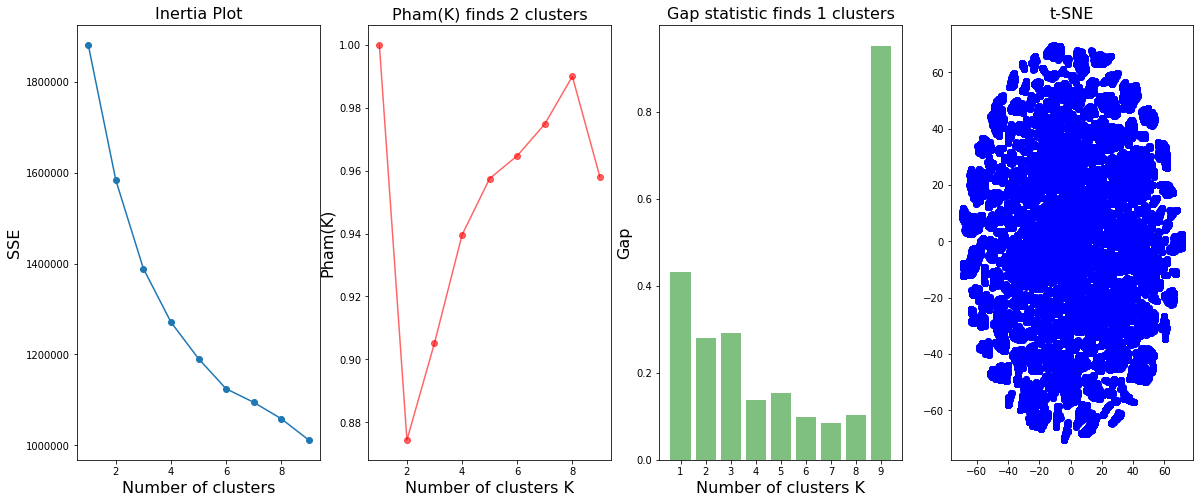

In [31]:
C.plot()